In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from aefc_vortex.math_module import xp, xcipy, ensure_np_array
from aefc_vortex import utils
from aefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from aefc_vortex import dm
from aefc_vortex import props
from aefc_vortex import efc_2dm as efc
import aefc_vortex.fresnel_2dm_96 as fresnel
import aefc_vortex.fraunhofer_2dm_96 as fraunhofer

Nwaves = 9
wavelength_c = 650e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
control_waves = bandpasses[:, Nwaves_per_bp//2]
print(control_waves)

dm1_flat = xp.rot90(xp.rot90( utils.load_fits('../data/dm1_flat_command.fits') ))

/home/kianmilani/Projects/adefc-vortex/adefc_vortex
[[6.17500e-07 6.25625e-07 6.33750e-07]
 [6.41875e-07 6.50000e-07 6.58125e-07]
 [6.66250e-07 6.74375e-07 6.82500e-07]]
[6.25625e-07 6.50000e-07 6.74375e-07]


/home/kianmilani/Projects/adefc-vortex/adefc_vortex


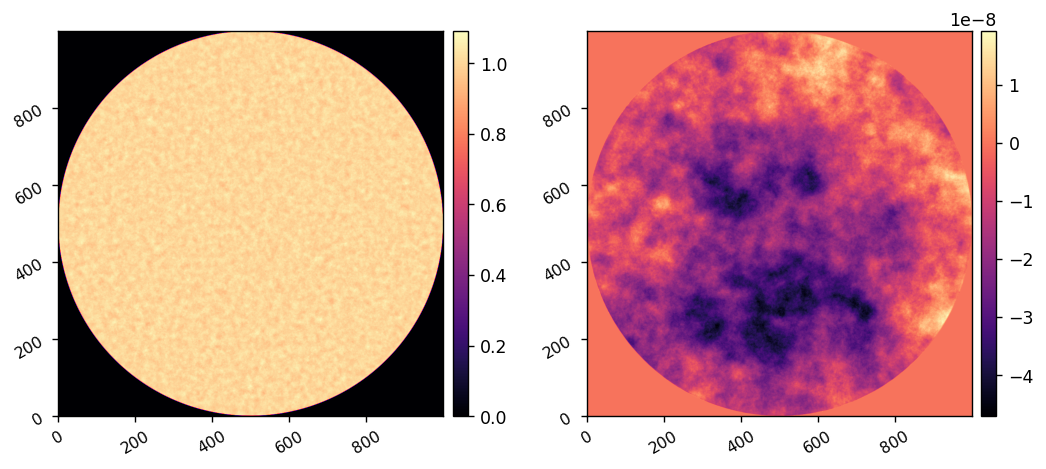

In [12]:
reload(fresnel)
I = fresnel.CORO(
    # dm1_ref=dm1_flat,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


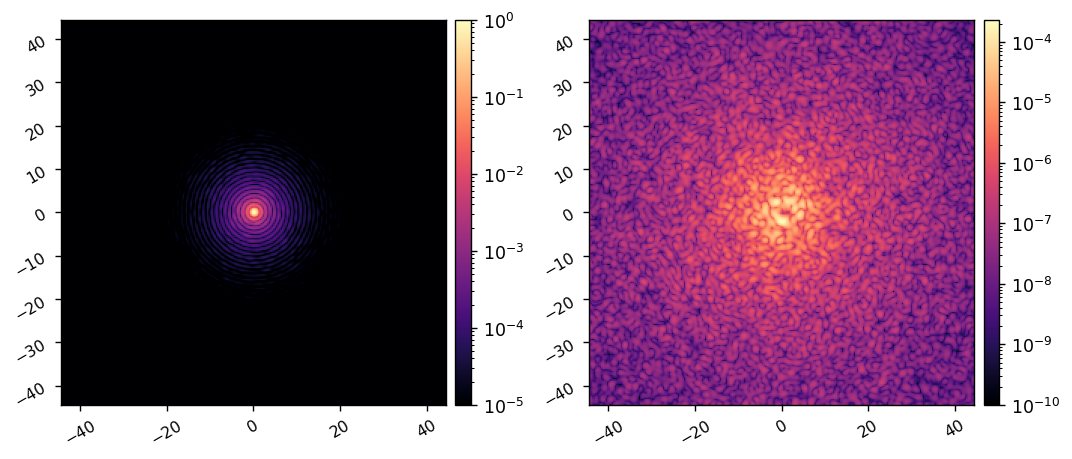

In [13]:
reload(fresnel)
reload(dm)
I = fresnel.CORO(
        # dm1_ref=dm1_flat,
)
I.use_opds = True
# I.bandpasses = bandpasses 

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


In [2]:
48/34, 48/64, 48/96

(1.411764705882353, 0.75, 0.5)

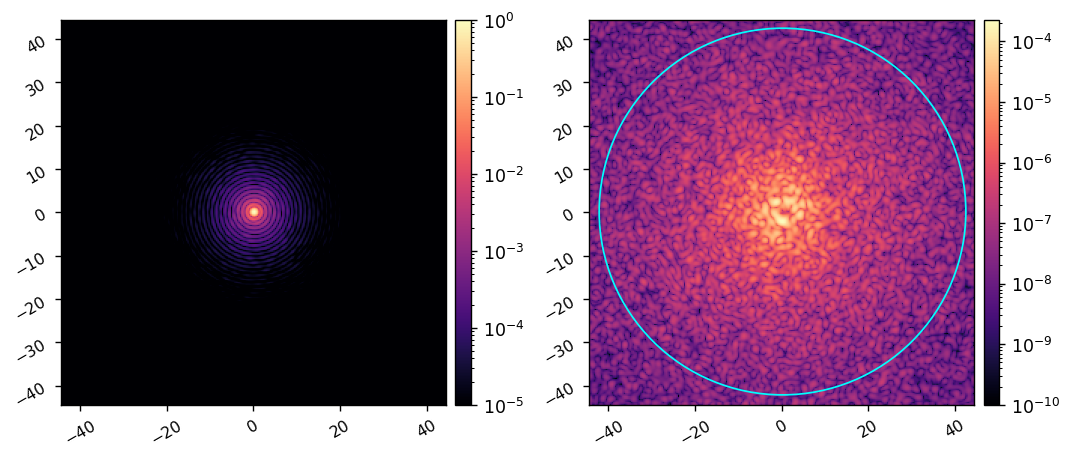

42.300000000000004

In [19]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(
    model_psf, model_coro_im,
    pxscl=M.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
    patches2=[Circle((M.psf_pixelscale_lamDc/2,M.psf_pixelscale_lamDc/2), M.control_rad, fill=False, color='cyan')]
)
M.control_rad

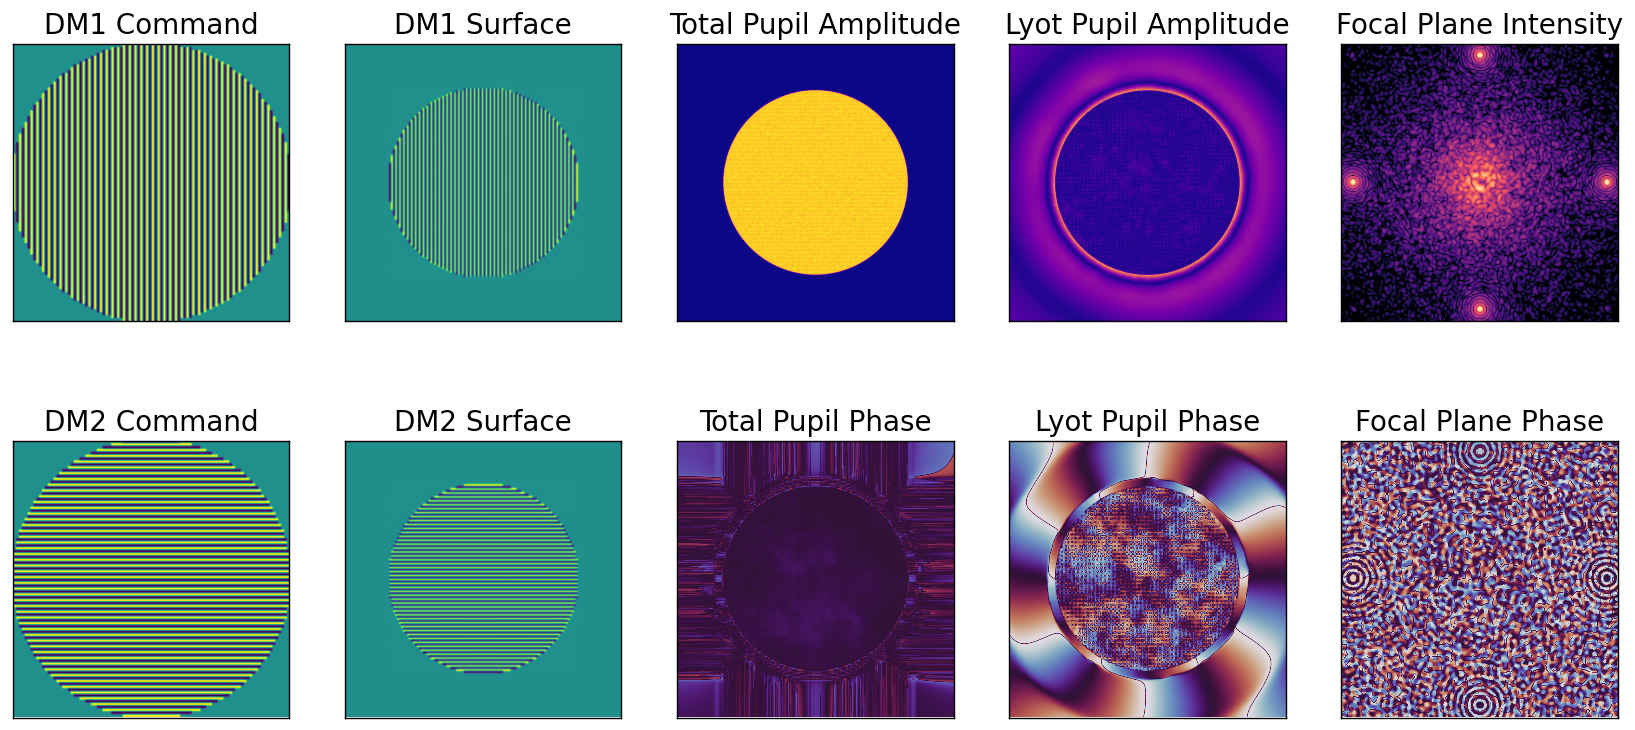

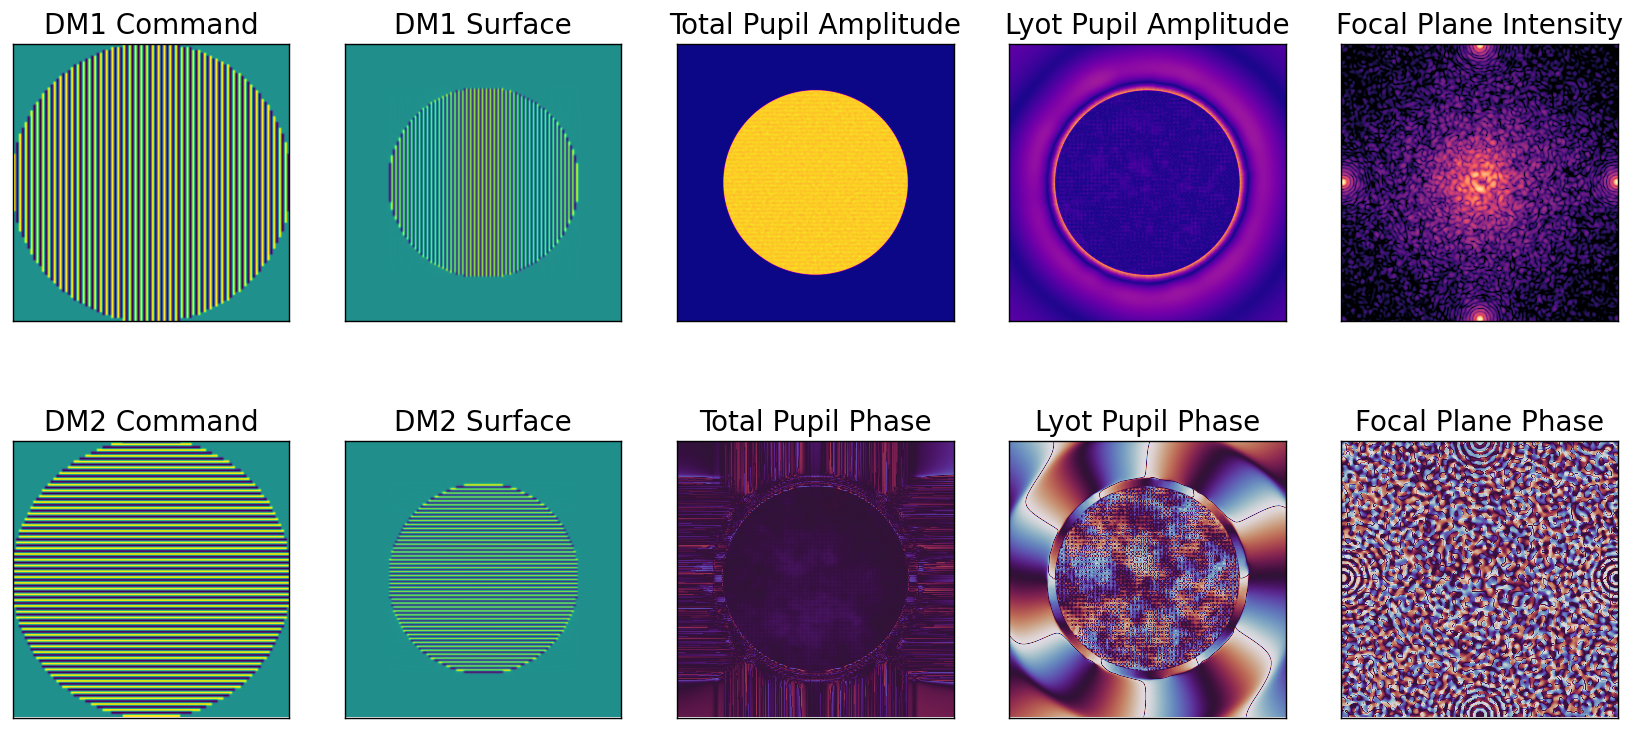

In [ ]:
dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )

# dm1_command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))

# dm1_command = 2.5e-9*utils.make_fourier_command(x_cpa=17, y_cpa=0, Nact=M.Nact)
# dm2_command = 2.5e-9*utils.make_fourier_command(x_cpa=0, y_cpa=17, Nact=M.Nact)

dm1_command = 2.5e-9*utils.make_fourier_command(x_cpa=48, y_cpa=0, Nact=M.Nact)
dm2_command = 2.5e-9*utils.make_fourier_command(x_cpa=0, y_cpa=48, Nact=M.Nact)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf_1 = M.forward(acts, control_waves[0], use_vortex=1, fancy_plot=1)
fpwf_2 = M.forward(acts, control_waves[-1], use_vortex=1, fancy_plot=1)